In [1]:
import multiprocess as mp
import tqdm
import numpy as np
import pickle
from astropy.table import Table

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from NoiseSOM import *
from pipeline_tools import *

# SOM Outlier Analysis

The BFD trained SOM has a few outliers in the top right corner, let's take a closer look at these

In [3]:
fname = '../data/wide_field_data/BFD/VALIDATION_CAT_1E+05.fits'
t = Table.read(fname, format='fits')

In [4]:
filename = '../outputs/BFD/assignments.pkl'
with open(filename, 'rb') as f:
    assignments = pickle.load(f)

t['Wide Cell Assignment'] = assignments

In [5]:
fluxes_colname = 'Mf_per_band'
fluxes_err_colname = 'cov_Mf_per_band'

### Calculating aggregate properties of the galaxies in each cell

Here we use the [astropy aggregate function](https://docs.astropy.org/en/stable/api/astropy.table.TableGroups.html#astropy.table.TableGroups.aggregate) to group the table based on the wide cell assignments and perform aggregate functions on them, in this case average and standard deviation. 

In [6]:
mags = flux_to_mag(t[fluxes_colname].data)
bands = ['g', 'r', 'i', 'z']
for i,b in enumerate(bands):
    t['%s_mag'%b] = mags[:,i]
    
colors = ['g-r', 'r-i', 'i-z']
for i, c in enumerate(colors):
    t[c] = mags[:,i]-mags[:,i+1]

grouped_by_wc = t.group_by('Wide Cell Assignment')
averages = grouped_by_wc.groups.aggregate(np.nanmean)
stddev = grouped_by_wc.groups.aggregate(np.nanstd)

/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:6: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f) + const
/Users/danecross/Desktop/SOMs/SOM-photoz-BFD/src/pipeline_tools.py:6: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(f) + const
/Users/danecross/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


## Plots!

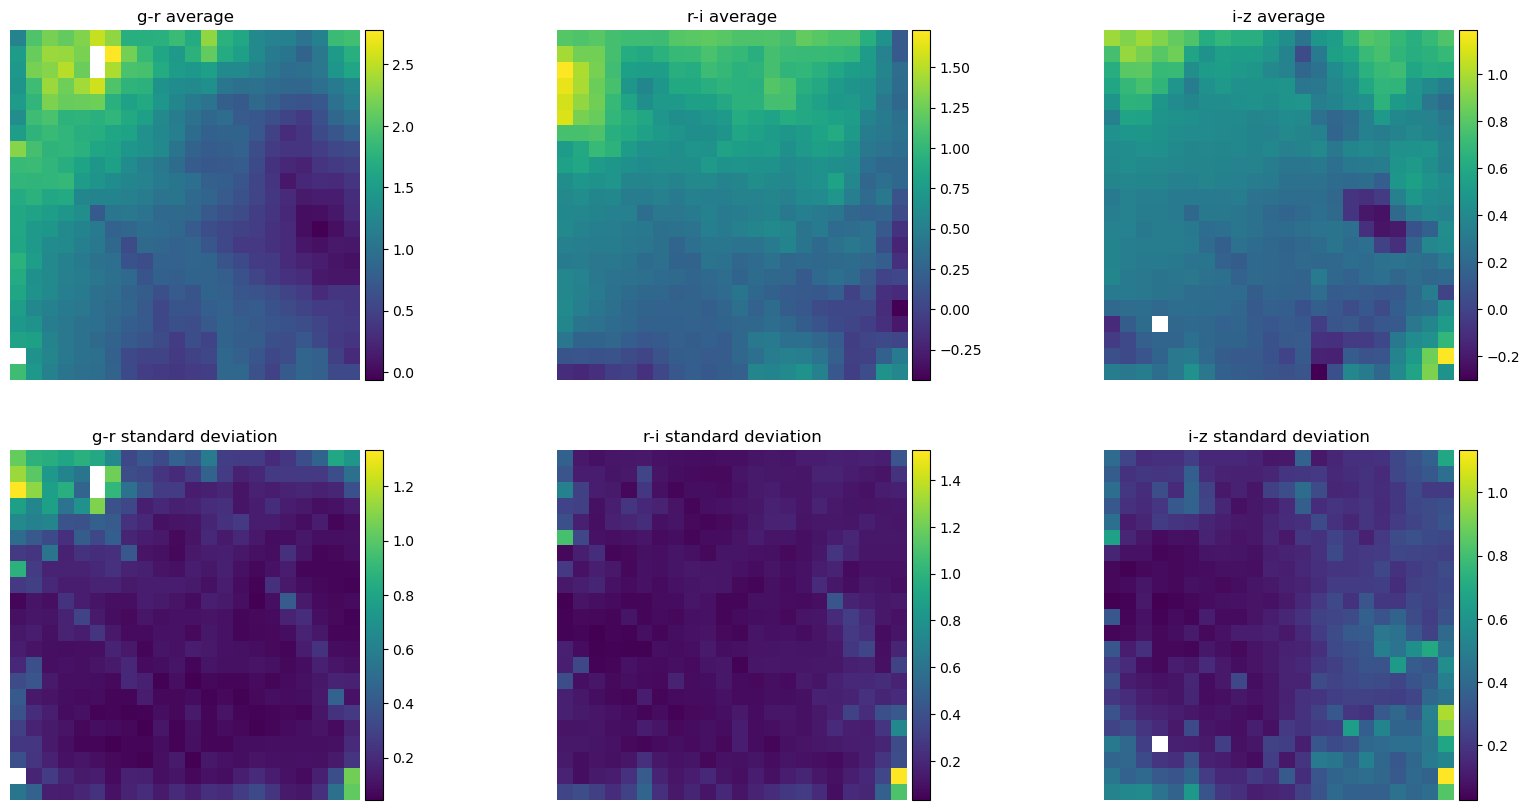

In [7]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

for a,c in zip(axs.T,colors):
    
    im0=a[0].imshow(averages[c].reshape(22,22)) ; a[0].set_title(label=c+' average')
    im1=a[1].imshow(stddev[c].reshape(22,22)) ; a[1].set_title(label=c+' standard deviation')
    
    a[0].axis('off')
    a[1].axis('off')
    
    divider = make_axes_locatable(a[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')
    
    divider = make_axes_locatable(a[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    
plt.show()

# Grab & Study Outliers

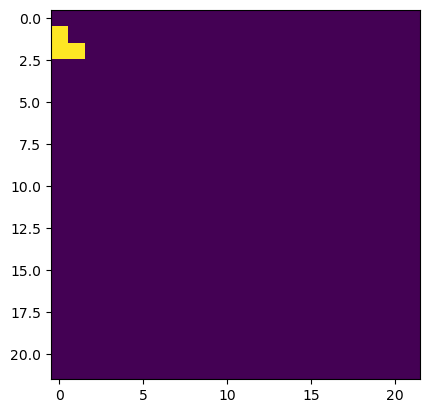

In [8]:
outlying_cells = np.where((stddev['g-r']>1.1))[0]

mask = np.zeros((22*22))
mask[outlying_cells] = 1

plt.imshow(mask.reshape(22,22))

In [9]:
t_mask = np.array([cell in outlying_cells for cell in t['Wide Cell Assignment']])
outliers = t[t_mask]

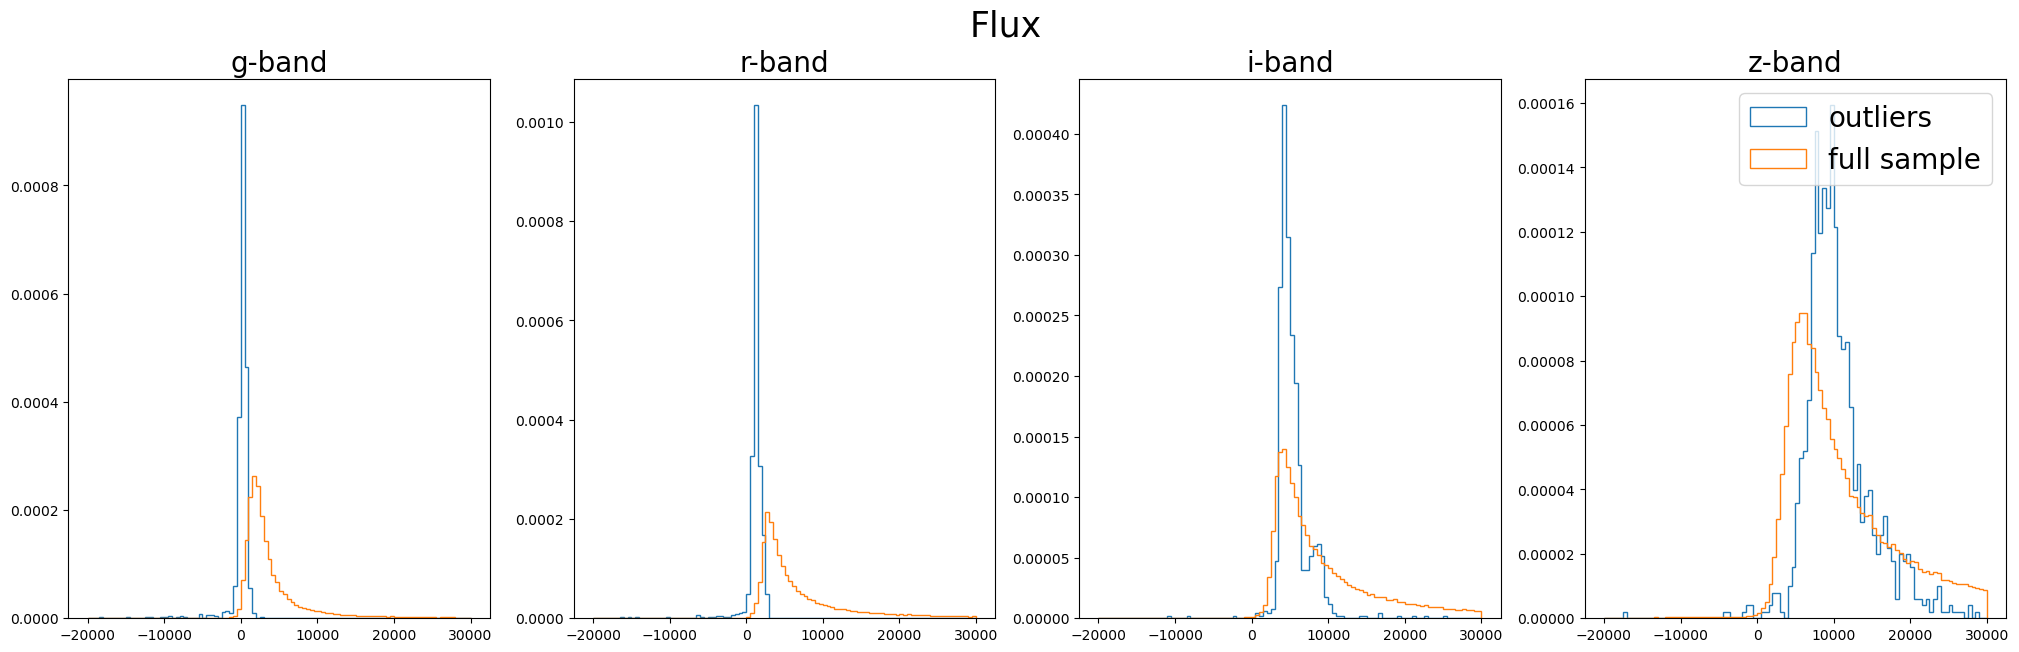

In [10]:
fig, axs = plt.subplots(1,4, figsize=(25,7))

r = (-20000, 30000)
[a.hist(outliers['Mf_per_band'][:,i], 100, range=r, histtype='step', density=True, label='outliers') for i,a in enumerate(axs)]
[a.hist(t['Mf_per_band'][:,i], 100, range=r, histtype='step', density=True, label='full sample') for i,a in enumerate(axs)]
[a.set_title(f+'-band', fontsize=20) for a,f in zip(axs,['g', 'r', 'i', 'z'])]

plt.suptitle('Flux', fontsize=25)
plt.legend(fontsize=20)
plt.show()

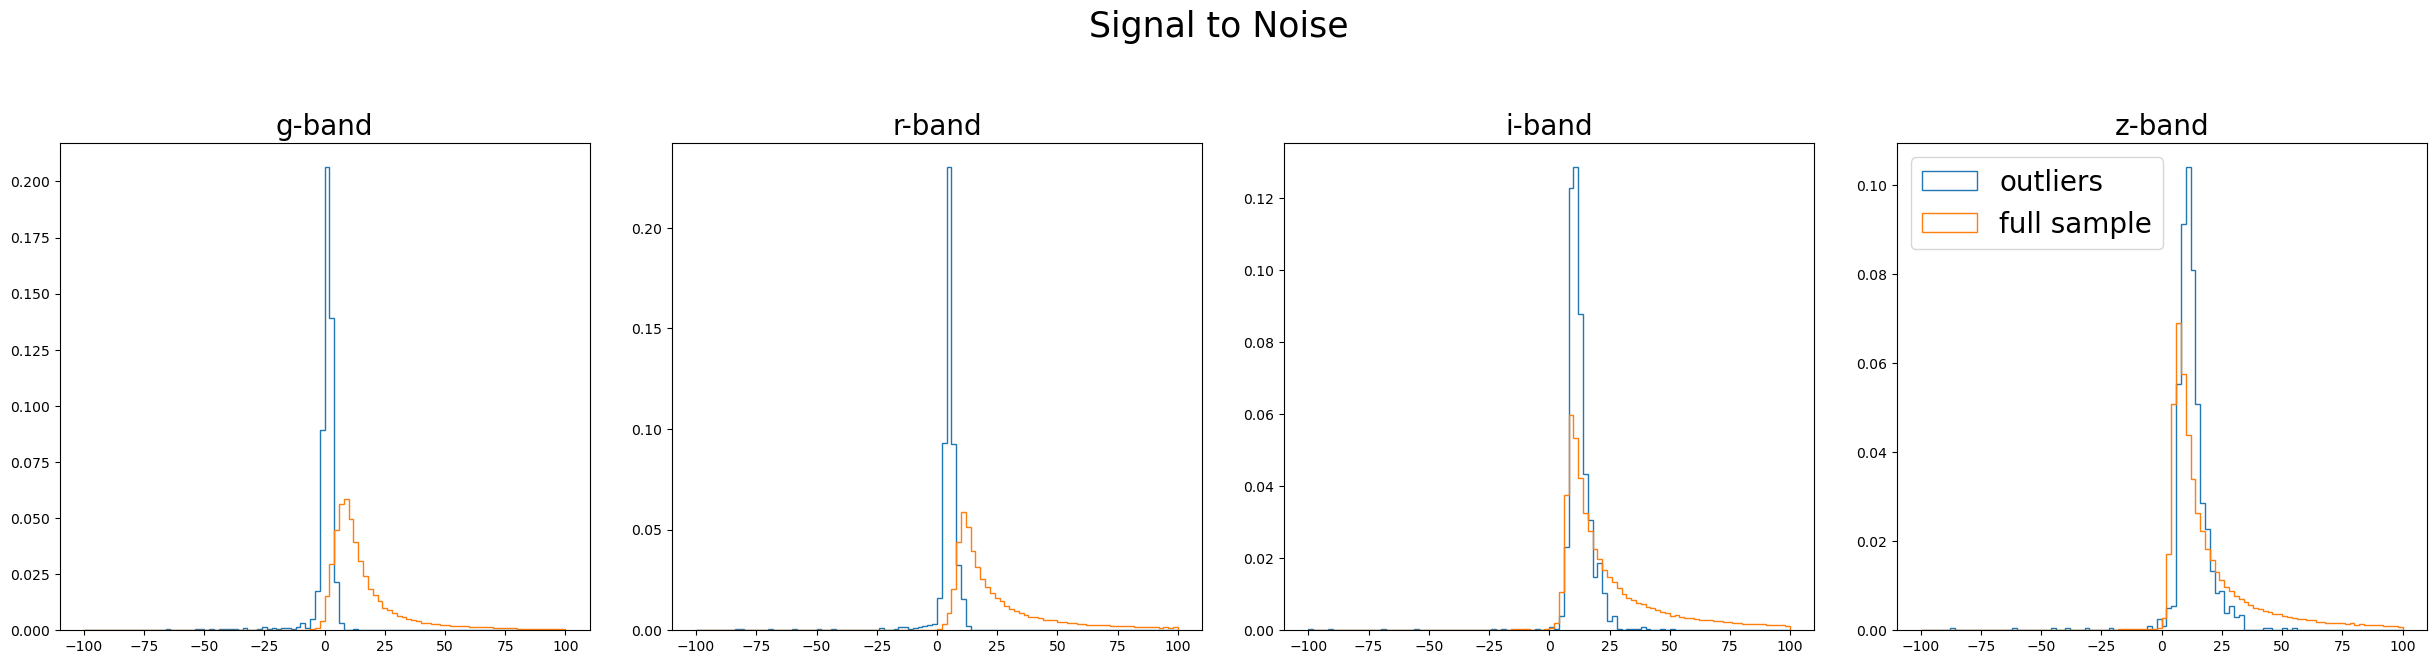

In [11]:
fig, axs = plt.subplots(1,4, figsize=(25,7), sharex=True)

r = (-100, 100)
[a.hist(outliers['Mf_per_band'][:,i]/np.sqrt(outliers['cov_Mf_per_band'][:,i]), 
        100, range=r, histtype='step', density=True, label='outliers') for i,a in enumerate(axs)]
[a.hist(t['Mf_per_band'][:,i]/np.sqrt(t['cov_Mf_per_band'][:,i]), 
        100, range=r, histtype='step', density=True, label='full sample') for i,a in enumerate(axs)]
[a.set_title(f+'-band', fontsize=20) for a,f in zip(axs,list('griz'))]

plt.suptitle('Signal to Noise', fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=3)
plt.show()

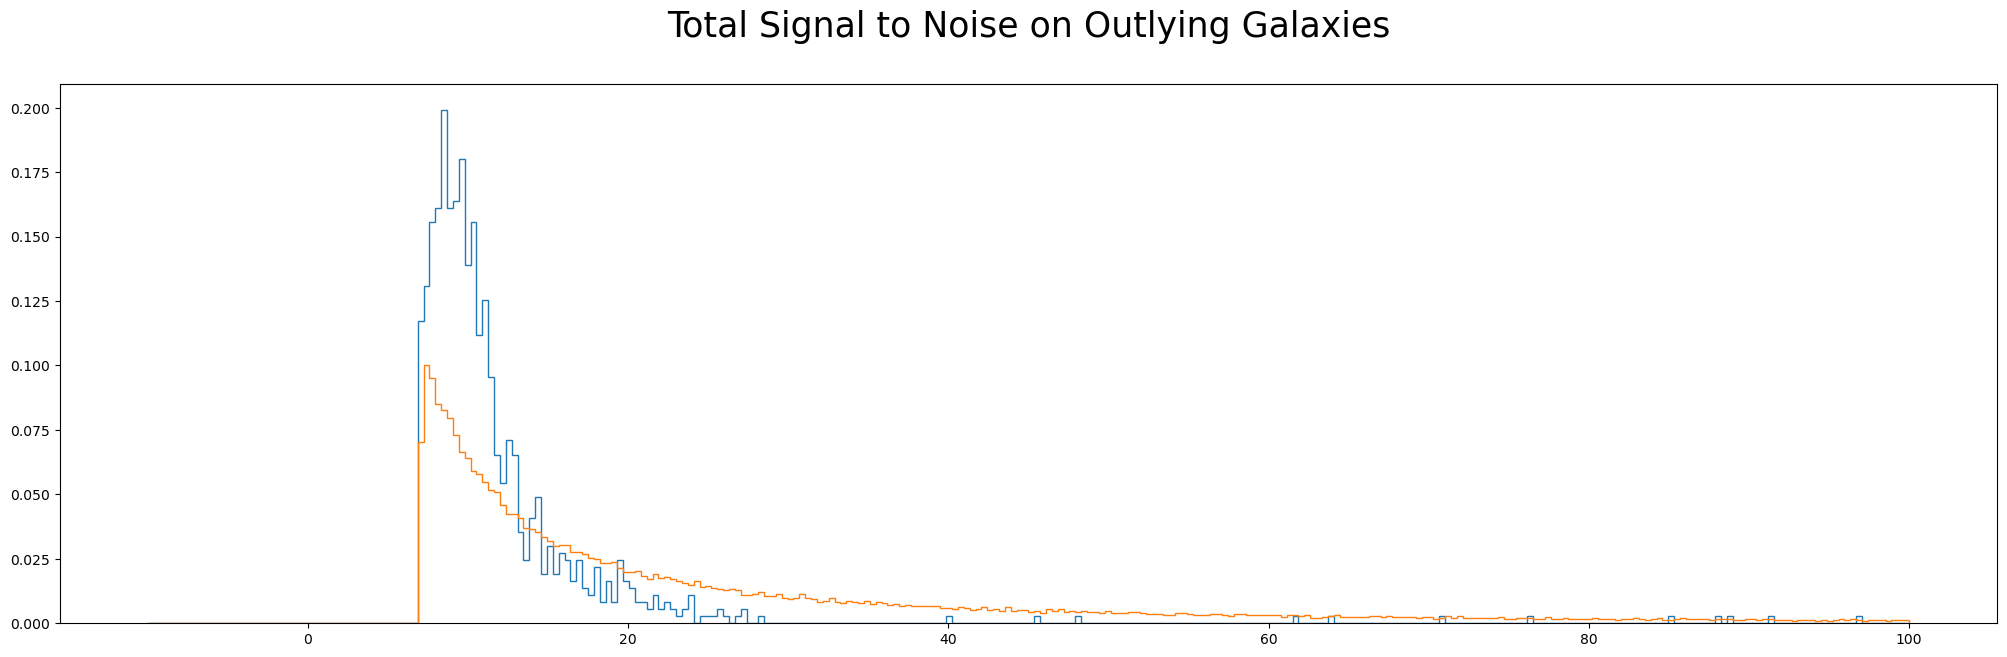

In [12]:
out_SN = SN(outliers['Mf_per_band'],np.sqrt(outliers['cov_Mf_per_band']))
norm_SN = SN(t['Mf_per_band'],np.sqrt(t['cov_Mf_per_band']))

r = (-10, 100)
[plt.hist(sample, 300, range=r, histtype='step', density=True) for sample in [out_SN, norm_SN]]

plt.gcf().set_size_inches((25,7))
plt.title("Total Signal to Noise on Outlying Galaxies\n", fontsize=25)
plt.show()